#**1. Import các thư viện cần thiết:**

In [15]:
!pip install unidecode

In [16]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#**2. Tải bộ dữ liệu:**

In [17]:
!gdown --id 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
!unzip dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /content/dataset.zip
100% 230k/230k [00:00<00:00, 19.2MB/s]
Archive:  dataset.zip
replace dataset/all-data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/all-data.csv    


#**3. Đọc bộ dữ liệu:**

In [18]:
dataset_path = 'dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(dataset_path,
                 names=headers,
                 encoding='ISO-8859-1')

In [19]:
classes = {class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])

#**4. Tiền xử lý dữ liệu:**

In [20]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

    return text

In [21]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))

#**5. Xây dựng bộ từ vựng:**

In [22]:
vocab = []
for sentence in df['content'].tolist():
    tokens = sentence.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [23]:
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except:
            w_ids = word_to_idx['UNK']
        tokens.append(w_ids)

    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]

    return tokens

#**6. Chia bộ dữ liệu train, val, test:**

In [24]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

#**7. Xây dựng pytorch datasets:**

In [25]:
class FinancialNews(Dataset):
    def __init__(
        self,
        X, y,
        word_to_idx,
        max_seq_len,
        transform=None
    ):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(text, self.word_to_idx, self.max_seq_len)
        text = torch.tensor(text)

        return text, label

#**8. Khai báo dataloader:**

In [26]:
max_seq_len = 32

train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

#**9. Xây dựng mô hình:**

In [27]:
class SentimentClassifier(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim,
        hidden_size, n_layers, n_classes,
        dropout_prob
    ):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(
            embedding_dim, hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size * 2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.bilstm(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [28]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

#**10. Cài đặt hàm loss và optimizer:**

In [29]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr)

#**11. Thực hiện huấn luyện:**

In [30]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [31]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [32]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 0.9420	Val loss: 0.9265
EPOCH 2:	Train loss: 0.9332	Val loss: 0.9275
EPOCH 3:	Train loss: 0.9353	Val loss: 0.9272
EPOCH 4:	Train loss: 0.9337	Val loss: 0.9281
EPOCH 5:	Train loss: 0.9333	Val loss: 0.9260
EPOCH 6:	Train loss: 0.9326	Val loss: 0.9259
EPOCH 7:	Train loss: 0.9341	Val loss: 0.9261
EPOCH 8:	Train loss: 0.9255	Val loss: 0.9255
EPOCH 9:	Train loss: 0.9367	Val loss: 0.9252
EPOCH 10:	Train loss: 0.9343	Val loss: 0.9252
EPOCH 11:	Train loss: 0.9276	Val loss: 0.9250
EPOCH 12:	Train loss: 0.9317	Val loss: 0.9262
EPOCH 13:	Train loss: 0.9296	Val loss: 0.9252
EPOCH 14:	Train loss: 0.9303	Val loss: 0.9250
EPOCH 15:	Train loss: 0.9289	Val loss: 0.9248
EPOCH 16:	Train loss: 0.9277	Val loss: 0.9236
EPOCH 17:	Train loss: 0.9310	Val loss: 0.9273
EPOCH 18:	Train loss: 0.9266	Val loss: 0.9231
EPOCH 19:	Train loss: 0.9328	Val loss: 0.9223
EPOCH 20:	Train loss: 0.9270	Val loss: 0.9227
EPOCH 21:	Train loss: 0.9176	Val loss: 0.9223
EPOCH 22:	Train loss: 0.9186	Val loss: 0.92

#**12. Đánh giá mô hình:**

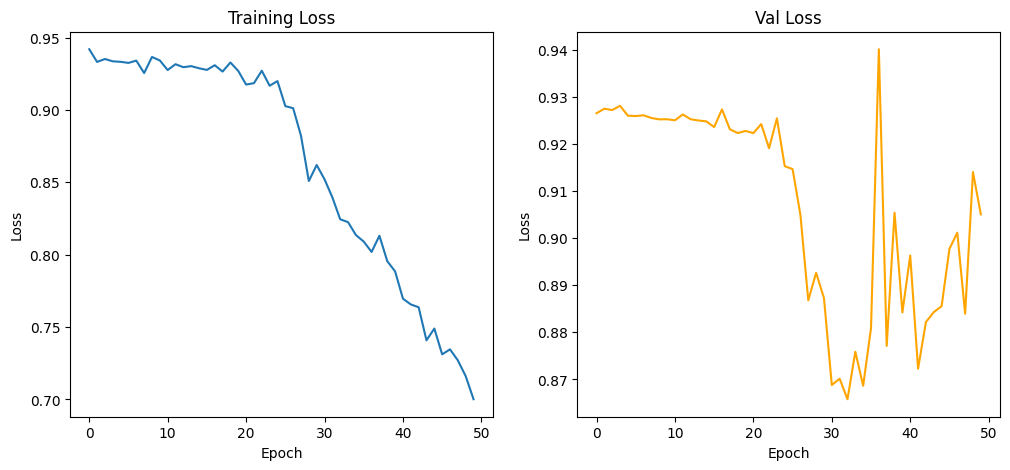

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [34]:

val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6144329896907217
Test accuracy:  0.6314432989690721
